In [51]:
import torch
import matplotlib.pyplot as plt
import math

In [27]:
# I just think XOR is a nice problem that easily introduces
# vanishing gradients on a naive setup using MSE

xs = torch.tensor([[0.0, 0.0], [0.0, 1.0], [1.0, 0.0], [1.0, 1.0]])
ys = torch.tensor([[0.0], [1.0], [1.0], [0.0]])

In [ ]:
# Toy example using 0 fancy features except the autograd for backprop

class Activation: pass
class ReLU(Activation):
    def __call__(self, val: torch.Tensor):
        return val.relu()
class Sigmoid(Activation):
    def __call__(self, val: torch.Tensor):
        return val.sigmoid()
class Tanh(Activation):
    def __call__(self, val: torch.Tensor):
        return val.tanh()

class Layer:
    def __init__(self, inp, out): # out == number of neurons
        torch.manual_seed(2468)
        gain = math.sqrt(2 / (inp + out))

        # Note: for some reason, reshape(R, C) disables the gradients
        self.w = torch.empty(out, inp, requires_grad=True, dtype=torch.float32)
        torch.nn.init.xavier_uniform_(self.w, gain)

        self.b = torch.rand(out, 1, requires_grad=True, dtype=torch.float32)
        torch.nn.init.xavier_uniform_(self.w, gain)

        # if torch.accelerator.is_available():
        #     self.w = self.w.to(torch.accelerator.current_accelerator())
        #     self.b = self.b.to(torch.accelerator.current_accelerator())

    def forward(self, x):
        # if torch.accelerator.is_available():
        #     x = x.to(torch.accelerator.current_accelerator())
        # (N, I) . (I, 1) + (N, 1) = (N, 1)
        # print("W=", self.w.shape, " @ X=", x.shape, " + B=", self.b.shape)
        return self.w @ x + self.b
       

class MLP:
    def __init__(self, nout, lrate, layers: list[Layer]):
        self.nout = nout
        self.lrate = lrate
        self.layers = layers
        self.losses = []

    def forward(self, x):
        for layer in self.layers:
            if isinstance(layer, Layer):
                x = layer.forward(x)
            elif isinstance(layer, Activation):
                x = layer(x)
            else:
                raise ValueError("Unknown layer type")
        if x.numel() != self.nout:
            raise ValueError(f"MLP expects {self.nout} outputs, got {x.numel()} instead")
        return x

    def train(self, epoch=100):
        for i in range(epoch):
            self.reset()
            loss = 0.0
            for x, y in zip(xs, ys):
                h = self.forward(x.view(len(x), 1))
                term = (y.reshape(self.nout, 1) - h) ** 2
                loss += term.sum() / term.numel()

            loss /= len(xs)
            self.losses.append(loss.item())

            loss.backward()

            self.optimize()

        print(f"{i+1}.. Loss {loss.item()}")
        return self

    def params(self):
        params = []
        for layer in self.layers:
            if isinstance(layer, Layer):
                params += [layer.w, layer.b]
        return params

    def reset(self):
        for p in self.params():
            p.grad = None

    def optimize(self):
        with torch.no_grad():
            for p in self.params():
                p.data += -self.lrate * p.grad

5000.. Loss 0.11940038204193115


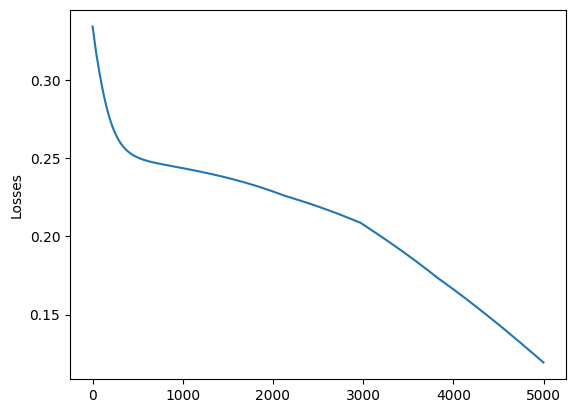

In [61]:
# This setup is completely arbitrary
# but we basically want to overfit for XOR
nout = 1
lrate = 0.01
mlp = MLP(nout, lrate, [
    Layer(2, 4), 
    ReLU(),
    Layer(4, 1),
    Sigmoid()
]).train(epoch=5000)

plt.plot(mlp.losses)
plt.ylabel("Losses")
plt.show()

In [63]:
# if loss is stuck at 0.25, that means we get 0.5 for all examples 
with torch.no_grad():
    for x, y in zip(xs, ys):
        h = mlp.forward(x.view(len(x), 1)).data
        print(f"Predictions: {h.round().item()} vs {y.item()}")


Predictions: 0.0 vs 0.0
Predictions: 1.0 vs 1.0
Predictions: 1.0 vs 1.0
Predictions: 0.0 vs 0.0


hello
